In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import tempfile
import tensorflow as tf
import time

from tf_rl.controller import DiscreteDeepQ
from tf_rl.simulation import Main
from tf_rl import simulate
from tf_rl.models import MLP

from __future__ import print_function

In [3]:
LOG_DIR = tempfile.mkdtemp()
print(LOG_DIR)

/tmp/tmp424q2F


In [4]:
current_settings = {
    'objects': [
        'friend',
        'enemy',
        'square',
    ],
    'colors': {
        'hero':   'yellow',
        'friend': 'green',
        'enemy':  'red',
        'square': 'red',
    },
    'object_reward': {
        'friend': 100,
        'enemy': 0,
        'square': 0
    },
    'hero_bounces_off_walls': False,
    'world_size': (700,500),
    'hero_initial_position': [600, 440],
    'hero_initial_speed':    [0,   0],
    'hero_initial_accel': [0, 0],
    "maximum_speed":         [50, 50],
    "object_radius": 10.0,
    "num_objects": {
        "friend" : 1,
        "enemy" :  1,
        "square" : 1,
    },
    "num_observation_lines" : 32,
    "observation_line_length": 120.,
    "tolerable_distance_to_wall": 700,
    "wall_distance_penalty":  -0.0,
    "speed":0,
    "accel":5,
    "minimum_success_rate": 1.0,
    "Timeout": 3.0
}

In [5]:
notString = False
notRight = True
saver = False
while(notRight):
    try:
        choice = input("(A)Start new Experiment" + "\n"+"(B)Reload from file?" + "\n")
        if(choice == "A" or choice =="a"):
            notString = True
            notRight = False
        if(choice == "B" or choice == "b"):
            notRight = False
            notString = True
            saver = True
        if (not notString):
            print("Please enter A or B")
    except (NameError,SyntaxError):
        print("Please enter as a string")
        
brainName = "null"
while(notString):
    try:
        if(not saver):
            brainName = input("Enter new brain file name: ")
        else:
            brainName = input("Enter brain file name: (.ckpt not included) ")
        notString = False
    except (NameError,SyntaxError):
        print("Please enter as a string")

(A)Start new Experiment
(B)Reload from file?
"a"
Enter new brain file name: "check"


In [6]:
g = Main(current_settings,brainName)# create the game simulator


check.pdf
check.txt


In [7]:
human_control = False

if human_control:
    # WSAD CONTROL (requires extra setup - check out README)
    current_controller = HumanController({b"w": 3, b"d": 0, b"s": 1,b"a": 2,}) 
else:
    # Tensorflow business - it is always good to reset a graph before creating a new controller.
    tf.python.framework.ops.reset_default_graph()
    session = tf.InteractiveSession()

    # This little guy will let us run tensorboard
    #      tensorboard --logdir [LOG_DIR]
    journalist = tf.train.SummaryWriter(LOG_DIR)

    # Brain maps from observation to Q values for different actions.
    # Here it is a done using a multi layer perceptron with 2 hidden
    # layers
    brain = MLP([g.observation_size,], [200, 200, g.num_actions], 
                [tf.tanh, tf.tanh, tf.identity])
    
    # The optimizer to use. Here we use RMSProp as recommended
    # by the publication
    optimizer = tf.train.RMSPropOptimizer(learning_rate= 0.001, decay=0.9)

    # DiscreteDeepQ object
    current_controller = DiscreteDeepQ(g.observation_size, g.num_actions, brain, optimizer, session,brainName,
                                       discount_rate=0.99, exploration_period=5000, max_experience=10000, 
                                       store_every_nth=4, train_every_nth=4,
                                       summary_writer=journalist)

    
    session.run(tf.initialize_all_variables())
    session.run(current_controller.target_network_update)
    # graph was not available when journalist was created  
    journalist.add_graph(session.graph_def)
    
    if(saver):
        notFound = True
        while(notFound):
            string = "../saved_brains/" + brainName + ".ckpt"
            try:
                current_controller.saver.restore(session,string)
                notFound = False
                current_controller.bN = brainName
                g.brainName = brainName
                journalist.add_graph(session.graph_def)
                print("Running: " + brainName + ".ckpt")
            except(tf.errors.NotFoundError):
                brainName = input("File does not exist try again: ")

                    
    

In [8]:
FPS          = 200
ACTION_EVERY = 3
    
fast_mode = True
if fast_mode:
    WAIT, VISUALIZE_EVERY = False, 10
else:
    WAIT, VISUALIZE_EVERY = True, 1

    
try:
    start_time = time.time()
    with tf.device("/cpu:0"):
        simulate(simulation=g,
                 controller=current_controller,
                 fps=FPS,
                 visualize_every=VISUALIZE_EVERY,
                 action_every=ACTION_EVERY,
                 wait=WAIT,
                 disable_training=False,
                 simulation_resolution=0.001,
                 save_path=None)
except (KeyboardInterrupt,IndexError):
    g.saveTotals()
    print("Complete")
    runTime = time.time() - start_time
    print("Total RunTime: " + str(runTime))
    print("LearningTime: " + str(g.learntime))
    print("SimulationTime: " + str(runTime - g.learntime))

<tf_rl.utils.svg.Scene instance at 0x7f460411ba28>

[  1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   8.55603787e-01   6.62804569e-01
   5.36045899e-01   4.19934992e-01   3.55550298e-01   3.53859536e-01
   3.39916237e-01   3.36795438e-01   3.85566702e-01   3.94306683e-01
   4.77295375e-01   6.06979155e-01   8.96737172e-01   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00

In [9]:
session.run(current_controller.target_network_update)

In [10]:
current_controller.q_network.input_layer.Ws[0].eval()

array([[-0.01557533, -0.10824189, -0.02460197, ...,  0.01523064,
         0.10435347, -0.03503321],
       [ 0.05249989, -0.02670862, -0.06682696, ..., -0.10012835,
         0.10060503, -0.04407267],
       [ 0.02092397,  0.10870093,  0.06104353, ..., -0.11155497,
         0.00301465, -0.00306379],
       ..., 
       [-0.09830444,  0.05671409,  0.04534231, ..., -0.02860206,
         0.04314227,  0.09561589],
       [-0.05576154, -0.02149902,  0.02579527, ...,  0.05170998,
         0.07071856,  0.00498738],
       [-0.02948587,  0.0603701 ,  0.09567198, ...,  0.10490571,
         0.0215513 , -0.01550082]], dtype=float32)

In [11]:
current_controller.target_q_network.input_layer.Ws[0].eval()

array([[-0.01557533, -0.10824189, -0.02460197, ...,  0.01523064,
         0.10435347, -0.03503606],
       [ 0.05249989, -0.02670862, -0.06682696, ..., -0.10012835,
         0.10060503, -0.04407552],
       [ 0.02092397,  0.10870093,  0.06104353, ..., -0.11155497,
         0.00301465, -0.00306664],
       ..., 
       [-0.09830444,  0.05671409,  0.04534231, ..., -0.02860206,
         0.04314227,  0.09561574],
       [-0.05576154, -0.02149902,  0.02579527, ...,  0.05170998,
         0.07071856,  0.00326138],
       [-0.02948587,  0.0603701 ,  0.09567198, ...,  0.10490571,
         0.0215513 , -0.0154724 ]], dtype=float32)

# Average Reward over time

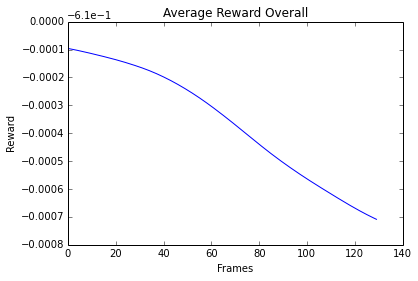

In [12]:
g.plot_reward(smoothing=100)

# Visualizing what the agent is seeing

Starting with the ray pointing all the way right, we have one row per ray in clockwise order.
The numbers for each ray are the following:
- first three numbers are normalized distances to the closest visible (intersecting with the ray) object. If no object is visible then all of them are $1$. If there's many objects in sight, then only the closest one is visible. The numbers represent distance to friend, enemy and wall in order.
- the last two numbers represent the speed of moving object (x and y components). Speed of wall is ... zero.

Finally the last two numbers in the representation correspond to speed of the hero.

In [13]:
g.__class__ = Main
np.set_printoptions(formatter={'float': (lambda x: '%.2f' % (x,))})
x = g.observe()
new_shape = (x[:-2].shape[0]//g.eye_observation_size, g.eye_observation_size)
#print(x[:-2].reshape(new_shape))
print(x[-2:])
g.to_html()

[1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.86 0.66 0.54 0.42 0.36
 0.35 0.34 0.34 0.39 0.39 0.48 0.61 0.90 1.00 1.00 1.00 1.00 1.00 1.00 1.00
 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
 1.00 1.00 1.00 1.00 0.30 0.24 610.70 -10.28]
[610.70 -10.28]


<tf_rl.utils.svg.Scene instance at 0x7f45e769ac68>